In [23]:
import os
import sys
import requests
import datetime
import pandas as pd
import numpy as np
import torch, torchvision, torchaudio
import pytorch_lightning as pl
import wandb
import json
import copy
import shutil
import matplotlib.pyplot as plt
import time


from torchmetrics.detection import MeanAveragePrecision
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger
from transformers import AutoImageProcessor, DetrForObjectDetection
from transformers import DetrConfig, DetrImageProcessor
from pytorch_lightning import Trainer
from PIL import Image, ImageDraw

In [24]:


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, image_name):
        ann_file = os.path.join(img_folder, image_name)
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create Train and Validation Dataset
  #Minimal Dataset
# train_dataset = CocoDetection(img_folder='../../../old/BAA/Data/train', processor=processor, image_name="coco_train.json")
# val_dataset = CocoDetection(img_folder='../../../old/BAA/Data/val', processor=processor, image_name="coco_val.json")

  #Maximal Dataset
train_dataset = CocoDetection(img_folder='../../../old/BAA/Data/train_max', processor=processor, image_name="coco_train_max.json")
val_dataset = CocoDetection(img_folder='../../../old/BAA/Data/val_max', processor=processor, image_name="coco_val_max.json")

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))



loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 859
Number of validation examples: 215


In [29]:



class Detr(pl.LightningModule):
		def __init__(self, lr, lr_backbone, weight_decay):
			super().__init__()
			# replace COCO classification head with custom head
			# we specify the "no_timm" variant here to not rely on the timm library
			# for the convolutional backbone
			self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
																revision="no_timm",
																num_labels=len(id2label),
																ignore_mismatched_sizes=True)
			# see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
			self.processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
			self.cmetric = MeanAveragePrecision(iou_type="bbox")
			self.val_epoch_count = 0 # to not log at the first run
			self.save_hyperparameters()
			self.lr = lr
			self.lr_backbone = lr_backbone
			self.weight_decay = weight_decay
			self.training_step_pred = []
			self.training_step_targ = []
			self.validation_step_pred = []
			self.validation_step_targ = []

		def forward(self, pixel_values, pixel_mask):
			outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

			return outputs

		def common_step(self, batch, batch_idx, t_v):
			pixel_values = batch["pixel_values"]
			pixel_mask = batch["pixel_mask"]
			labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]
			outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
			loss = outputs.loss
			loss_dict = outputs.loss_dict
			
			if t_v:
				self.data_prep_train(pixel_values, pixel_mask, labels)
			else:
				self.data_prep_val(pixel_values, pixel_mask, labels)
			

			return loss, loss_dict

		def training_step(self, batch, batch_idx):
			loss, loss_dict = self.common_step(batch, batch_idx, True)
			# logs metrics for each training_step,
			# and the average across the epoch
			self.log("training_loss", loss)
			for k,v in loss_dict.items():
				self.log("train_" + k, v.item())
			return loss

		def on_train_epoch_end(self) -> None:
			print("onTrainEpoch")
			t1 = time.time()
			self.cmetric = MeanAveragePrecision(iou_type="bbox")
			self.cmetric.update(self.training_step_pred, self.training_step_targ)
			result = self.cmetric.compute()
			counter = 0
			for k, v in result.items():
				counter += 1
				if counter < 15:
					wandb.log({"train_epoch_" + k: v.item()})
					print({"train_" + k: v.item()})
			self.training_step_pred = []
			self.training_step_targ = []
			t2 = time.time()
			print(round(t2 - t1, 4))
			
		# temp
		"""def on_train_end(self) -> None:
			print("onTrainEnd")
			t1 = time.time()
			self.cmetric = MeanAveragePrecision(iou_type="bbox")
			self.cmetric.update(self.training_step_pred, self.training_step_targ)
			result = self.cmetric.compute()
			counter = 0
			for k, v in result.items():
				counter += 1
				if counter < 15:
					wandb.log({"train_" + k: v.item()})
			self.training_step_pred = []
			self.training_step_targ = []
			t2 = time.time()
			print(round(t2 - t1, 4))"""

		def validation_step(self, batch, batch_idx):
			loss, loss_dict = self.common_step(batch, batch_idx, False)
			self.log("validation_loss", loss)
			for k,v in loss_dict.items():
				self.log("validation_" + k, v.item())

			return loss
		
		def on_validation_epoch_end(self) -> None:
			if self.val_epoch_count == 1:
				print("onValEpoch")
				t1 = time.time()
				self.cmetric = MeanAveragePrecision(iou_type="bbox")
				self.cmetric.update(self.training_step_pred, self.training_step_targ)
				result = self.cmetric.compute()
				counter = 0
				for k, v in result.items():
					counter += 1
					if counter < 15:
						wandb.log({"validation_epoch_" + k: v.item()})
						print({"validation_epoch_" + k: v.item()})
				self.validation_step_pred = []
				self.validation_step_targ = []
				t2 = time.time()
				print(round(t2 - t1, 4))
			else:
				self.val_epoch_count = 1

			
		#temp
		"""def on_validation_end(self) -> None:
			print("onValEnd")
			t1 = time.time()
			self.cmetric = MeanAveragePrecision(iou_type="bbox")
			self.cmetric.update(self.training_step_pred, self.training_step_targ)
			result = self.cmetric.compute()
			counter = 0
			for k, v in result.items():
				counter += 1
				if counter < 15:
					wandb.log({"validation_" + k: v.item()})
			self.validation_step_pred = []
			self.validation_step_targ = []
			t2 = time.time()
			print(round(t2 - t1, 4))"""

		def configure_optimizers(self):
			param_dicts = [
				{"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
				{
					"params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
					"lr": self.lr_backbone,
				},
			]
			optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
									weight_decay=self.weight_decay)

			return optimizer

		def train_dataloader(self):
			return train_dataloader

		def val_dataloader(self):
			return val_dataloader
		
		# EVALUATION

		def convert_to_xywh(self, boxes):
			xmin, ymin, xmax, ymax = boxes.unbind(1)
			return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

		def prepare_for_coco_detection(self, predictions):
			#used for the evaluation 
			coco_results = []
			for original_id, prediction in predictions.items():
				if len(prediction) == 0:
					continue

				boxes = prediction["boxes"]
				boxes = self.convert_to_xywh(boxes).tolist()
				scores = prediction["scores"].tolist()
				labels = prediction["labels"].tolist()

				coco_results.extend(
					[
						{
							"image_id": original_id,
							"category_id": labels[k],
							"bbox": box,
							"score": scores[k],
						}
						for k, box in enumerate(boxes)
					]
				)
			return coco_results
		
		def data_prep_train(self, pixel_values, pixel_mask, labels):

			with torch.no_grad():
				outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

			orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
			results = self.processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)
			for n in results:
				self.training_step_pred.append(n)
			for i in labels:
				self.training_step_targ.append({"boxes":i["boxes"], "labels":i["class_labels"]})

		def data_prep_val(self, pixel_values, pixel_mask, labels):

			with torch.no_grad():
				outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

			orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
			results = self.processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)
			for n in results:
				self.validation_step_pred.append(n)
			for i in labels:
				self.validation_step_targ.append({"boxes":i["boxes"], "labels":i["class_labels"]})


In [30]:
# Training




# login to weights and biases, to relogin: wandb.login(key="YOUR KEY", relogin=True)
wandb.login()

date = datetime.datetime.now()
run_name = "Run at the {}".format(date)

lr = 1e-4
lr_backbone=1e-5
weight_decay=1e-4

project = "BAA_Book_Damage_Detection"

wandb.init(
    project=project,
    name=run_name,
    config={"learning_rate_transformer": lr,
            "learning_rate_backbone": lr_backbone,
            "weight_decay": weight_decay,
            "architecture": "DETR",
            "dataset": "test_minimal_set",
            "train_set_size": len(train_dataset)}
    )

model = Detr(lr=lr, lr_backbone=lr_backbone, weight_decay=weight_decay)

model.to(device)

outputs = model(pixel_values=batch['pixel_values'].to(device), pixel_mask=batch['pixel_mask'].to(device))
print(outputs.logits.shape)

max_steps_var = 460

wandb_logger = WandbLogger("Optimize_Logging", "../models/", project=project, log_model=True, checkpoint_name=f"DETR_{max_steps_var}_Steps")
trainer = Trainer(max_steps=max_steps_var, gradient_clip_val=0.1, logger=wandb_logger)
trainer.fit(model)

wandb.finish()

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([11, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([11]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\loggers\wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogge

torch.Size([2, 100, 11])


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

onValEpoch
{'validation_epoch_map': 0.0}
{'validation_epoch_map_50': 0.0}
{'validation_epoch_map_75': 0.0}
{'validation_epoch_map_small': 0.0}
{'validation_epoch_map_medium': -1.0}
{'validation_epoch_map_large': -1.0}
{'validation_epoch_mar_1': 0.0}
{'validation_epoch_mar_10': 0.0}
{'validation_epoch_mar_100': 0.0}
{'validation_epoch_mar_small': 0.0}
{'validation_epoch_mar_medium': -1.0}
{'validation_epoch_mar_large': -1.0}
{'validation_epoch_map_per_class': -1.0}
{'validation_epoch_mar_100_per_class': -1.0}
13.3775
onTrainEpoch
{'train_map': 0.0}
{'train_map_50': 0.0}
{'train_map_75': 0.0}
{'train_map_small': 0.0}
{'train_map_medium': -1.0}
{'train_map_large': -1.0}
{'train_mar_1': 0.0}
{'train_mar_10': 0.0}
{'train_mar_100': 0.0}
{'train_mar_small': 0.0}
{'train_mar_medium': -1.0}
{'train_mar_large': -1.0}
{'train_map_per_class': -1.0}
{'train_mar_100_per_class': -1.0}
12.7974
onTrainEpoch
{'train_map': 0.0}
{'train_map_50': 0.0}
{'train_map_75': 0.0}
{'train_map_small': 0.0}
{'train

`Trainer.fit` stopped: `max_steps=460` reached.


In [12]:
NotImplementedError()

NotImplementedError()

In [6]:
# load the checkpoint

run = wandb.init()
artifact = run.use_artifact('damaged-books-detection-ml/BAA_Book_Damage_Detection/optimized_logs:v1', type='model')
artifact_dir = artifact.download()

model = Detr.load_from_checkpoint(artifact_dir + "/model.ckpt")



wandb: Downloading large artifact optimized_logs:v1, 296.87MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([11, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([11]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): ResNetBackbone(
            (embedder): ResNetEmbeddings(
              (embedder): ResNetConvLayer(
                (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                (normalization): DetrFrozenBatchNorm2d()
                (activation): ReLU()
              )
              (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            )
            (encoder): ResNetEncoder(
              (stages): ModuleList(
                (0): ResNetStage(
                  (layers): Sequential(
                    (0): ResNetBottleNeckLayer(
                      (shortcut): ResNetShortCut(
                        (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                        (normalization): DetrFrozenBatchNorm2d

In [8]:
# Evaluation

def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results




# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
      

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

    # provide to metric
    # metric expects a list of dictionaries, each item
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()
print(evaluator)

Running evaluation...


  0%|          | 0/108 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.16s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

{'scores': tensor([0.5069, 0.5348, 0.5655, 0.5224, 0.5745, 0.5763, 0.5804, 0.5032, 0.5308,
        0.5449, 0.5139, 0.5233], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[ 962.6388,  421.6771, 1017.8760,  578.0016],
        [1009.7476,  352.4882, 1071.0424,  506.3752],
        [ 863.4944,  377.8329,  927.7190,  571.3979],
        [ 513.9440,  354.7507,  598.7352,  482.9854],
        [ 910.3539,  385.0506,  977.2484,  566.5469],
        [ 748.6907,  307.1470,  857.7144,  413.4646],
        [ 635.5676,  360.9808,  732.2621,  574.4620],
        [1245.0476,  347.7908, 1300.7355,  570.0266],
        [ 784.2736,  416.6436,  856.7799,  574.7596],
        [ 954.8644,  332.4204, 1033.5022,  438.7649],
        [1073.4143,  308.0154, 1157.0238,  418.8813],
        [1051.6628,  372.5157, 1125.8613,  572.9125]], device='cuda:0')}
{'Schmutz': 12}
{'Schmutz': 13, 'Schäden': 4}


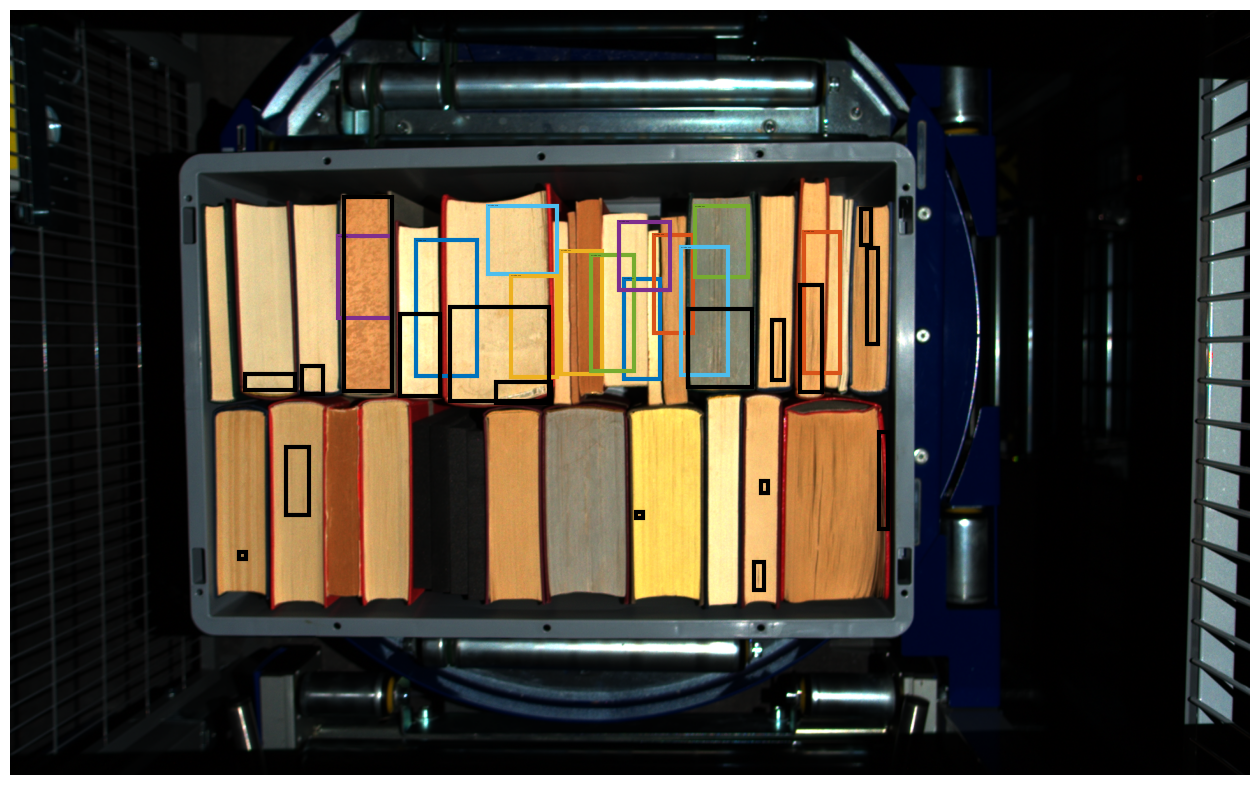

{'scores': tensor([0.5452, 0.5791, 0.5474, 0.5615, 0.5164, 0.5252, 0.6077, 0.5737, 0.5124,
        0.5361, 0.5049, 0.5418, 0.5186], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[1032.1823,  346.5072, 1096.9226,  555.3527],
        [ 830.1659,  346.9390,  910.7935,  559.1371],
        [ 520.2740,  350.8778,  596.3680,  497.6053],
        [ 904.8033,  352.5763,  977.5725,  560.6452],
        [1210.4556,  341.0266, 1269.8873,  559.8788],
        [ 997.1980,  363.2268, 1065.8975,  574.6104],
        [ 733.1694,  311.9692,  840.2440,  444.8620],
        [ 629.3465,  355.7626,  703.8491,  562.8845],
        [ 434.5212,  407.3447,  493.1606,  568.6978],
        [1262.4182,  358.5809, 1326.2720,  570.0792],
        [ 721.4809,  455.0458,  803.9934,  566.7366],
        [ 964.2297,  302.9017, 1046.7422,  420.3593],
        [1101.0952,  314.2669, 1170.7451,  445.3578]], device='cuda:0')}
{'Schmutz': 13}
{'Schmutz': 3, 'Schäden': 1}

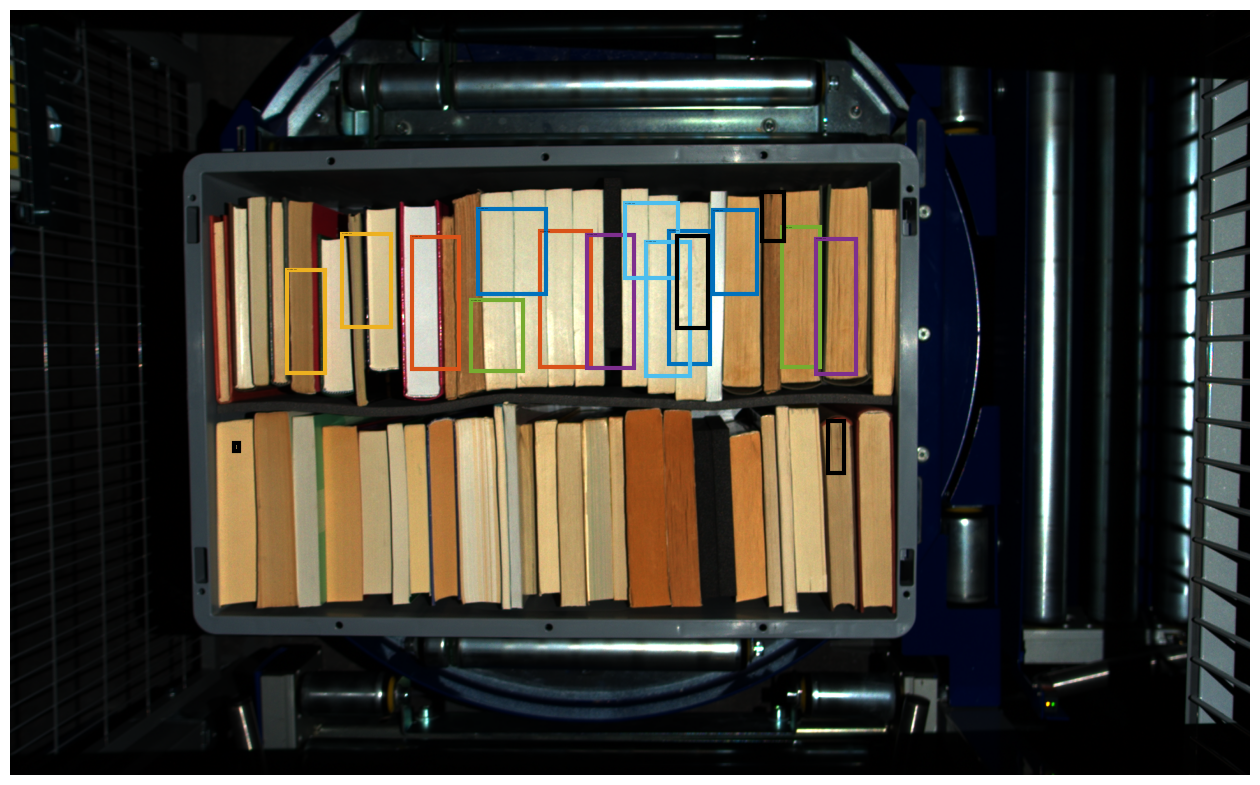

{'scores': tensor([0.5456, 0.5420, 0.5296, 0.5862, 0.5628, 0.5058], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[ 806.3208,  347.7027,  876.3644,  553.0486],
        [ 499.3639,  336.7062,  570.1486,  527.2483],
        [ 872.0749,  354.3106,  938.3200,  555.6115],
        [ 724.9218,  297.3061,  817.3968,  416.6865],
        [ 597.3380,  336.7734,  671.7816,  544.0581],
        [ 919.2242,  294.8145, 1022.0740,  407.3649]], device='cuda:0')}
{'Schmutz': 6}
{'Schmutz': 6, 'Sonstiges': 4, 'Wasser': 1}


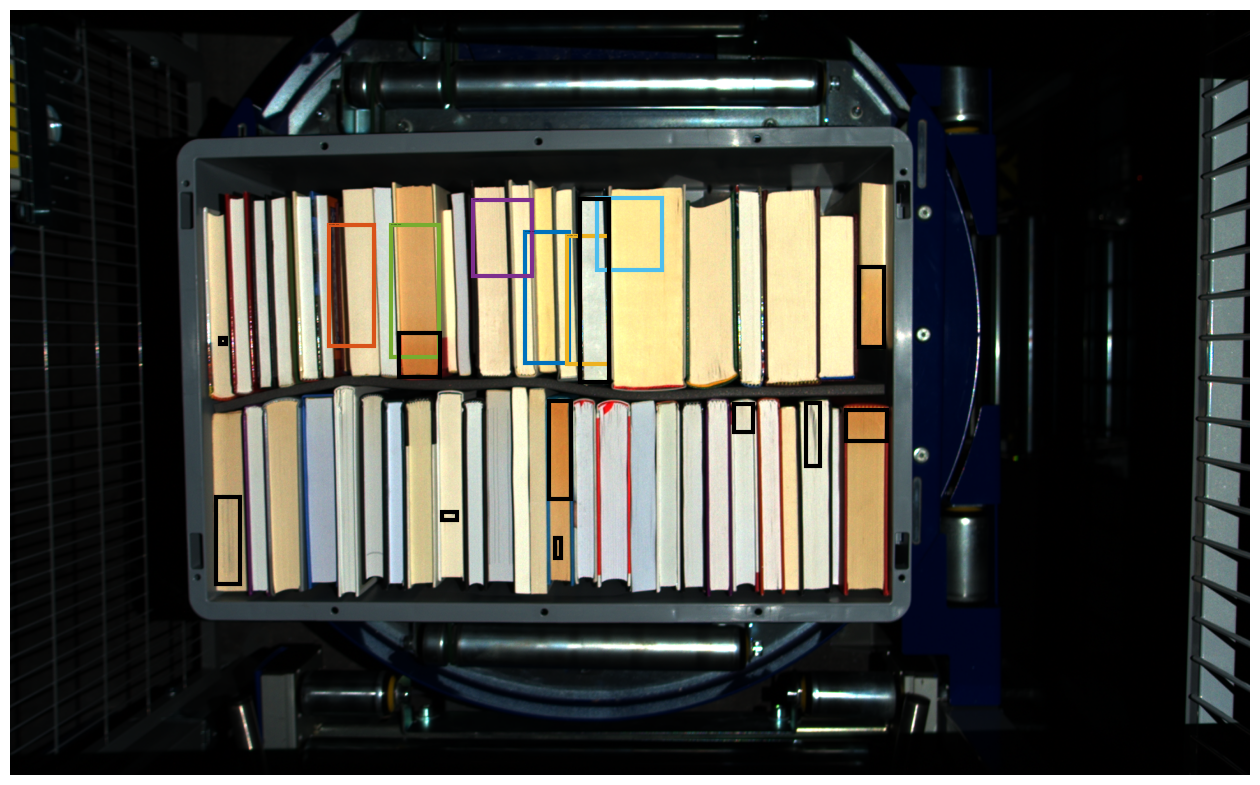

{'scores': tensor([0.5173, 0.5615, 0.5676, 0.5138, 0.5593, 0.6088, 0.5792, 0.5219, 0.5002],
       device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[1016.8948,  316.6360, 1087.7067,  509.4678],
        [ 821.6120,  320.7306,  901.0058,  507.2604],
        [ 502.6948,  320.7754,  579.6194,  505.2570],
        [ 461.3023,  284.2917,  557.7669,  385.3987],
        [ 888.6040,  323.9319,  964.9916,  504.6212],
        [ 702.4624,  301.3844,  796.3095,  485.7006],
        [ 622.2187,  315.9797,  702.3297,  507.7881],
        [ 926.3759,  308.3966, 1002.1700,  500.4674],
        [1058.8762,  305.3434, 1127.0844,  502.0107]], device='cuda:0')}
{'Schmutz': 9}
{'Schäden': 2, 'Wasser': 1, 'Schmutz': 2}


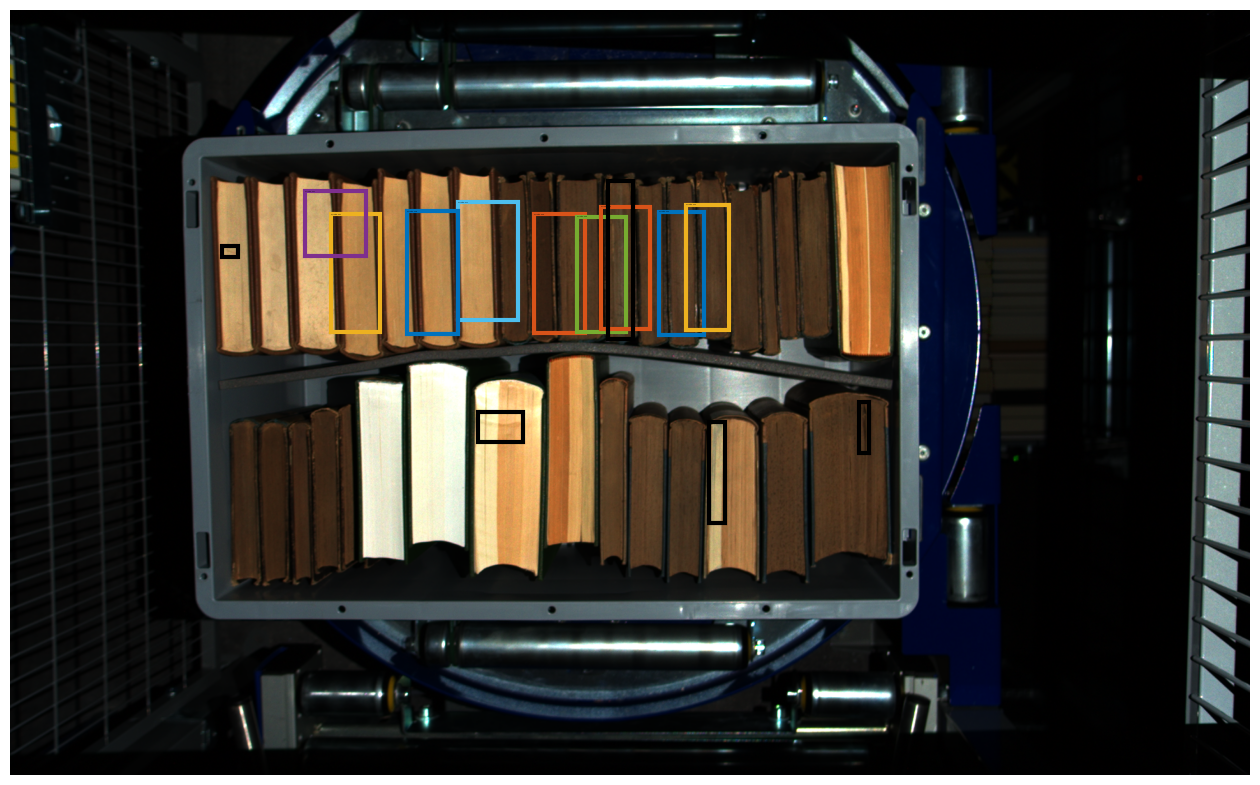

{'scores': tensor([0.5547, 0.5181, 0.5539, 0.5796, 0.5596, 0.5332], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[ 852.6918,  335.6695,  931.0316,  540.2864],
        [ 523.8880,  314.7277,  610.9271,  445.7238],
        [ 904.0570,  345.4200,  980.6953,  539.5682],
        [ 739.0891,  283.7338,  838.1664,  396.3727],
        [ 632.6754,  322.8907,  715.6752,  539.3010],
        [ 933.1545,  285.4925, 1018.9655,  400.5833]], device='cuda:0')}
{'Schmutz': 6}
{'Sonstiges': 2, 'Schmutz': 6}


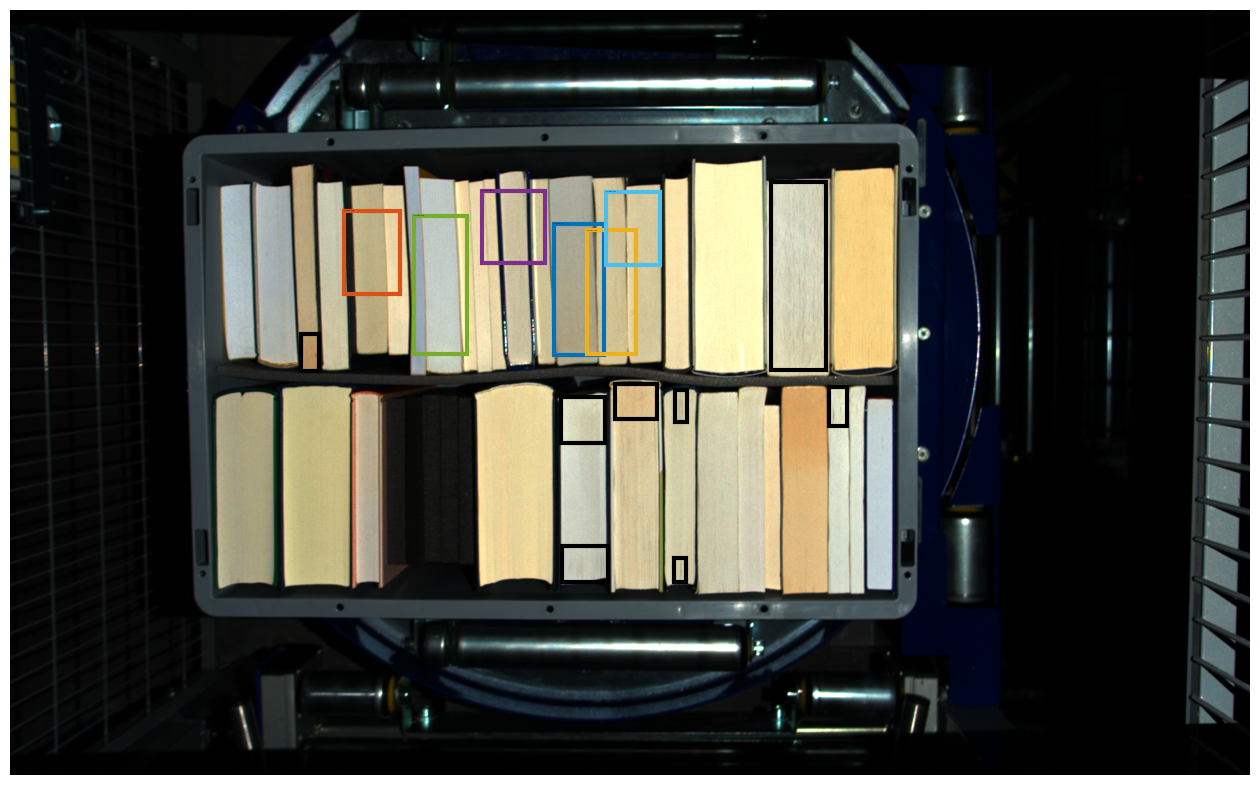

{'scores': tensor([0.5130], device='cuda:0'), 'labels': tensor([3], device='cuda:0'), 'boxes': tensor([[703.3099, 281.8979, 842.1716, 360.0762]], device='cuda:0')}
{'Schmutz': 1}
{'Schmutz': 5, 'Schäden': 3}


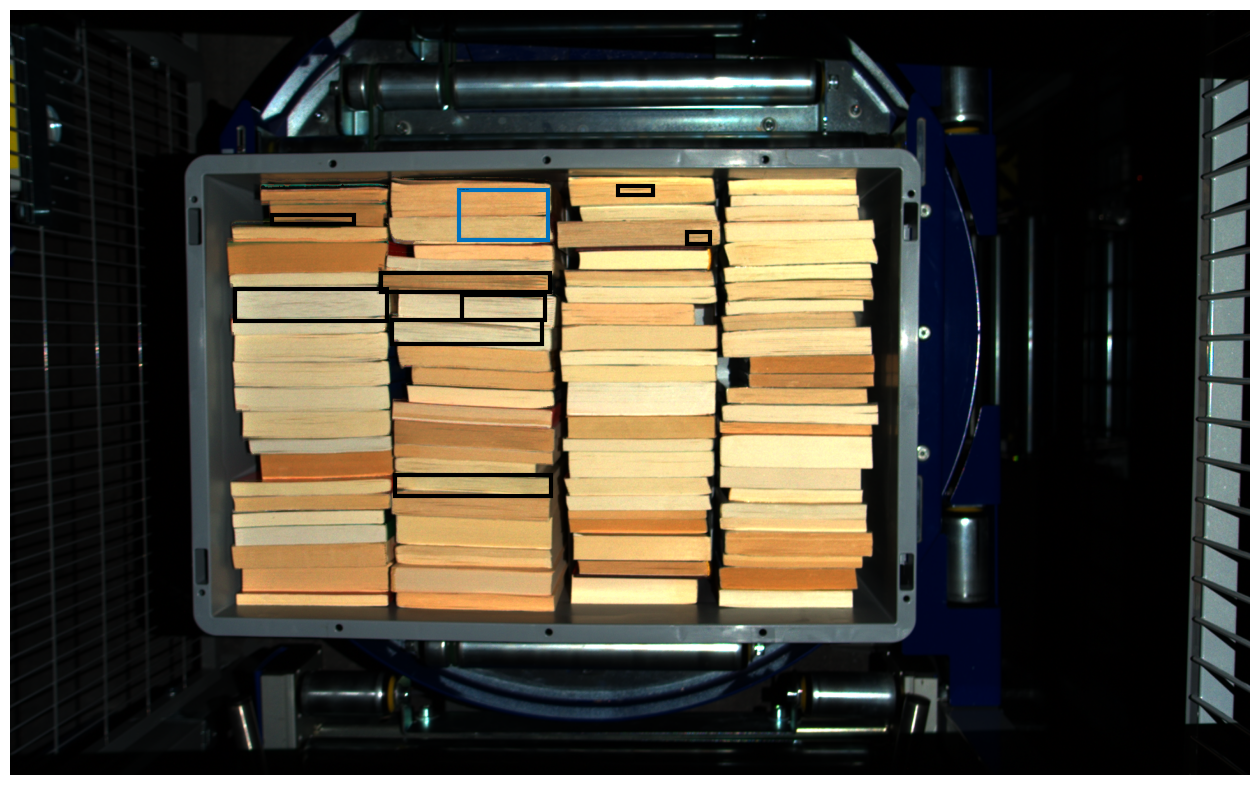

In [9]:
# Visualize
for z in range(6):
    pixel_values, target = val_dataset[z]
    pixel_values = pixel_values.unsqueeze(0).to(device)

    

    annotations = val_dataset.coco.imgToAnns["image_id"]

    with torch.no_grad():
        # forward pass to get class logits and bounding boxes
        outputs = model(pixel_values=pixel_values, pixel_mask=None)

    # colors for visualization
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
            [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

    def plot_results(pil_img, scores, labels, boxes, anno):
        plt.figure(figsize=(16,10))
        plt.imshow(pil_img)
        ax = plt.gca()
        colors = COLORS * 100
        types = {}
        for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=c, linewidth=3))
            text = f'{id2label[label]}: {score:0.2f}'
            textx = text.split(": ")
            if textx[0] in types:
                types.update({textx[0]: types[textx[0]] + 1})
            else: 
                types.update({textx[0]:1})
            ax.text(xmin, ymin, text, fontsize=0,
                    bbox=dict(facecolor='yellow', alpha=0.0))
        print(types)
        
        # draw annotatet boxes
        typesAnno = {}
        color = [0.000, 0.000, 0.000]
        # TODO Resize bbox
        for annot in anno:
            (x, y, w, h) = annot["bbox"]
            (xmin, ymin, xmax, ymax) = (x, y, x + w, y + h)
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=color, linewidth=3))
            text = f'{id2label[annot["category_id"]]}'
            if text in typesAnno:
                typesAnno.update({text: typesAnno[text] + 1})
            else: 
                typesAnno.update({text:1})
            ax.text(xmin, ymin, text, fontsize=0,
                    bbox=dict(facecolor='yellow', alpha=0.0))
        print(typesAnno)
        plt.axis('off')
        plt.show()

    # load image based on ID
    image_id = target['image_id'].item()
    image = val_dataset.coco.loadImgs(image_id)[0]
    anno = val_dataset.coco.imgToAnns[image_id]
    image = Image.open(os.path.join('../../../old/BAA/Data/val_max', image['file_name']))

    # postprocess model outputs
    width, height = image.size
    postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                    target_sizes=[(height, width)],
                                                                    threshold=0.5)
    results = postprocessed_outputs[0]
    print(results)
    plot_results(image, results['scores'], results['labels'], results['boxes'], anno)


## Export predictions of new images

In [10]:
pixel_values, target = val_dataset[0]
pixel_values = pixel_values.unsqueeze(0).to(device)

print(pixel_values.shape)

torch.Size([1, 3, 800, 1296])


In [11]:
def writeJson(jsonObject, filename):
    if filename.split(".")[-1] != "json":
        filename = f"{filename}.json"
    with open(filename, "w") as g:
        g.write(jsonObject)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path_new_images = "../new_images/"
path_predictions = "../predicted_images"
input_file = "coco_new.json"
pred_coco_filename = "coco_predictions.json"
threshold_postprocessing = 0.5 # zu 50% sicher ist sich das modell, dass dies ein schaden ist

list_paths = [os.path.join(path_new_images, filename) for filename in os.listdir(path_new_images) if
                            filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]


processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

new_dataset = CocoDetection(img_folder=path_new_images, processor=processor, image_name=input_file)

print("Number of training examples:", len(new_dataset))

# Copy json if not in folder else create
pred_path = os.path.join(path_predictions, pred_coco_filename)

with open(os.path.join(path_new_images, input_file), "r") as f:
    coco_tmp = json.load(f)

if os.path.exists(pred_path):
    with open(pred_path, "r") as f:
        coco_predict = json.load(f)
    
    # append image infos
    for x in coco_tmp["images"]:
        tmp = True
        for z in coco_predict["images"]:
            if x["id"] == z["id"]:
                tmp = False
        if tmp:
            coco_predict["images"].append(x)

else:
    coco_predict = copy.copy(coco_tmp)

# start id for annotations
if coco_predict["annotations"] == []:
    id_count = 0
else:
    id_count = coco_predict["annotations"][-1]["id"] + 1

for z in range(len(list_paths)):
    pixel_values, target = new_dataset[z]
    pixel_values = pixel_values.unsqueeze(0).to(device)

    with torch.no_grad():
        # forward pass to get class logits and bounding boxes
        outputs = model(pixel_values=pixel_values, pixel_mask=None)
    
    # postprocess model outputs
    width, height = target["size"]
    p_postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                    target_sizes=[(height, width)],
                                                                    threshold=threshold_postprocessing)
    # darf nur einmal durchlaufen, sonst gibts doppelte einträge
    for d in range(len(p_postprocessed_outputs[0]["labels"])):
        # Write predictions into annotations from pred_coco_filename
        # boxes == [xmin, ymin, xmax, ymax]
        box = p_postprocessed_outputs[0]["boxes"][d].tolist()
        dict_new_pred = {"id":id_count, 
                         "image_id":torch.Tensor.item(target["image_id"][0]), 
                         "category_id":int(p_postprocessed_outputs[0]["labels"][d]),
                         "segmentation":[], 
                         "bbox":p_postprocessed_outputs[0]["boxes"][d].tolist(), 
                         "ignore":0, 
                         "iscrowd":0, 
                         "area":((box[2]-box[0])*(box[3]-box[1]))}
        coco_predict["annotations"].append(dict_new_pred)
        id_count += 1

    for i in range(len(coco_tmp["images"])):
        if coco_tmp["images"][i]["id"] == torch.Tensor.item(target["image_id"][0]):
            del coco_tmp["images"][i]
    # move image to new location
    shutil.move(list_paths[z], os.path.join(path_predictions, list_paths[z].split("/")[-1]))



writeJson(json.dumps(coco_tmp, indent=4), os.path.join(path_new_images, input_file))
writeJson(json.dumps(coco_predict, indent=4), pred_path)
    

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 1


## Timestamps Testing

In [13]:
import time

In [21]:
t1 = time.time()
for x in range(9999999):
    x**2
t2 = time.time()

print(round(t2 - t1, 4))

1.7201
